# Data Collection and preprocessing

In [34]:
import pandas as pd

df_papyrus = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_chembl_2.csv")


In [3]:
df_papyrus_bar= pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_Barlow.csv")

In [35]:
df_papyrus

,SMILES,Target Name,Organism,UniProt ID,IC50,Target Sequence,Dataset,pChEMBL
0,O=C(Nc1ccccc1)C1CC(=O)N(C2CCCCC2)C1,Enoyl-[acyl-carrier-protein] reductase,Mycobacterium tuberculosis,P9WGR1,10660.0,MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRL...,ChEMBL,4.972243
1,O=C(Nc1ccccc1Br)C1CC(=O)N(C2CCCCC2)C1,Enoyl-[acyl-carrier-protein] reductase,Mycobacterium tuberculosis,P9WGR1,100000.0,MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRL...,ChEMBL,4.000000
2,O=C(Nc1ccc2c(c1)OCCO2)C1CC(=O)N(C2CCCCC2)C1,Enoyl-[acyl-carrier-protein] reductase,Mycobacterium tuberculosis,P9WGR1,100000.0,MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRL...,ChEMBL,4.000000
3,Cc1cccc(C)c1NC(=O)C1CC(=O)N(C2CCCCC2)C1,Enoyl-[acyl-carrier-protein] reductase,Mycobacterium tuberculosis,P9WGR1,100000.0,MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRL...,ChEMBL,4.000000
4,O=C(Nc1ccc(Oc2ccccc2)cc1)C1CC(=O)N(C2CCCCC2)C1,Enoyl-[acyl-carrier-protein] reductase,Mycobacterium tuberculosis,P9WGR1,100000.0,MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRL...,ChEMBL,4.000000
...,...,...,...,...,...,...,...,...
10912,CCNc1nc(Nc2c(CC)cccc2CC)ccc1OC,4'-phosphopantetheinyl transferase PptT,Mycobacterium tuberculosis,O33336,100000.0,MTVGTLVASVLPATVFEDLAYAELYSDPPGLTPLPEEAPLIARSVA...,ChEMBL,4.000000
10913,CCNc1cccc(Nc2c(CC)cc(S(=O)(=O)NCC)cc2CC)n1,4'-phosphopantetheinyl transferase PptT,Mycobacterium tuberculosis,O33336,1000.0,MTVGTLVASVLPATVFEDLAYAELYSDPPGLTPLPEEAPLIARSVA...,ChEMBL,6.000000
10914,CCNc1cccc(Nc2c(CC)cc(C(=O)NC)cc2CC)n1,4'-phosphopantetheinyl transferase PptT,Mycobacterium tuberculosis,O33336,3300.0,MTVGTLVASVLPATVFEDLAYAELYSDPPGLTPLPEEAPLIARSVA...,ChEMBL,5.481486
10915,CC(C)=CCC/C(C)=C/CNCCNC1C2CC3CC(C2)CC1C3,"(2Z,6E)-farnesyl diphosphate synthase",Mycobacterium tuberculosis,P9WFF5,50000.0,MEIIPPRLKEPLYRLYELRLRQGLAASKSDLPRHIAVLCDGNRRWA...,ChEMBL,4.301030


In [36]:
count = (df_papyrus["pChEMBL"]>6.5).sum()

print(f"Número de compostos com pChEMBL > 6: {count}")

Número de compostos com pChEMBL > 6: 2113


In [ ]:
# === métricas gerais ===
n_interactions = len(df_papyrus)
n_drugs = df_papyrus["SMILES"].nunique()
n_targets = df_papyrus["Target Sequence"].nunique()

# distribuição de classes
class_counts = df_papyrus_bar["label"].value_counts()
n_active = class_counts.get(1, 0)
n_inactive = class_counts.get(0, 0)

# tabela resumo
summary = pd.DataFrame({
    "Metric": [
        "Total interactions",
        "Unique drugs",
        "Unique targets",
        "Active interactions (label=1)",
        "Inactive interactions (label=0)"
    ],
    "Count": [
        n_interactions,
        n_drugs,
        n_targets,
        n_active,
        n_inactive
    ]
})

In [6]:
summary

,Metric,Count
0,Total interactions,522475
1,Unique drugs,349554
2,Unique targets,3531
3,Active interactions (label=1),276002
4,Inactive interactions (label=0),246415


# Barlow 

In [45]:
import os, json, pickle, textwrap
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


RUN_DIR = Path("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb")

import json, pickle

def load_history_any(path):
    if not path.exists():
        print(f"[warn] {path} não encontrado")
        return {}
    # 1) tenta JSON normal
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        pass
    # 2) tenta binário pickle
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"[erro] Não consegui ler {path} nem como JSON nem como Pickle: {e}")
        return {}

def load_history(path: Path):
    if not path.exists():
        print(f"[warn] history.json not found at: {path}")
        return {}
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, list):  # lista de épocas
        keys = sorted({k for d in data for k in d.keys()})
        out = {k: [] for k in keys}
        for d in data:
            for k in keys:
                out[k].append(d.get(k, None))
        return out
    elif isinstance(data, dict):
        return data
    else:
        print("[warn] formato estranho em history.json")
        return {}

def load_params(path: Path):
    if not path.exists():
        return None
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"[warn] não consegui carregar params.pkl: {e}")
        return None

def tail_file(path: Path, n=20):
    if not path.exists():
        return "[warn] log.txt não encontrado"
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    return "".join(lines[-n:])

def plot_metric_curves(hist: dict, metric_pairs, run_dir: Path):
    saved_paths = []
    epochs = None
    for v in hist.values():
        if isinstance(v, list):
            epochs = list(range(1, len(v)+1))
            break
    if epochs is None:
        return saved_paths

    for train_key, val_key, title in metric_pairs:
        if train_key in hist and val_key in hist:
            plt.figure()
            plt.plot(epochs, hist[train_key], label=train_key)
            plt.plot(epochs, hist[val_key], label=val_key)
            plt.xlabel("Epoch")
            plt.ylabel(title)
            plt.title(title)
            plt.legend()
            out = run_dir / f"{train_key}_vs_{val_key}.png"
            plt.savefig(out, dpi=200)
            plt.close()
            saved_paths.append(str(out))
    return saved_paths

# ---- load ----
history_path = RUN_DIR / "history.json"
params_path  = RUN_DIR / "params.pkl"
log_path     = RUN_DIR / "log.txt"

hist = load_history_any(history_path)
params = load_params(params_path)
log_tail = tail_file(log_path)

# mostrar últimos valores
if hist:
    last_vals = {k: (v[-1] if isinstance(v, list) and len(v)>0 else None) for k,v in hist.items()}
    df_last = pd.DataFrame(list(last_vals.items()), columns=["Metric","Last value"])
    print("\n=== Últimos valores do treino ===")
    print(df_last)

# gerar gráficos
metric_pairs = [
    ("loss", "val_loss", "Loss"),
    ("roc_auc", "val_roc_auc", "ROC-AUC"),
    ("pr_auc", "val_pr_auc", "PR-AUC"),
    ("f1", "val_f1", "F1-score"),
    ("accuracy", "val_accuracy", "Accuracy"),
]

saved = plot_metric_curves(hist, metric_pairs, RUN_DIR)

# mostrar params se existirem
if params is not None:
    print("\n=== Parâmetros de treino ===")
    print(params)

# mostrar último log
print("\n--- Últimas linhas de log.txt ---")
print(log_tail)

print("\nGráficos salvos em:", saved)



=== Últimos valores do treino ===
            Metric  Last value
0       train_loss  494.800273
1     on_diag_loss  135.667813
2    off_diag_loss  359.132462
3  validation_loss  943.495809

=== Parâmetros de treino ===
{'act_function': <class 'torch.nn.modules.activation.ReLU'>, 'loss_weight': 0.001, 'batch_size': 512, 'learning_rate': 0.0001, 'betas': (0.9, 0.999), 'step_size': 10, 'gamma': 0.1, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'momentum': 0.9, 'enc_n_neurons': 4096, 'enc_n_layers': 3, 'proj_n_neurons': 4096, 'proj_n_layers': 1, 'embedding_dim': 512, 'weight_decay': 0.0015, 'verbose': True, 'radius': 2, 'n_bits': 1024, 'aa_emb_size': 1024}

--- Últimas linhas de log.txt ---
  (enc_aa): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): BatchNorm1d(4096, eps=1e-05, mom

In [4]:
import pickle

RUN_DIR = "/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb"
params_path = Path(RUN_DIR) / "params.pkl"

with open(params_path, "rb") as f:
    params = pickle.load(f)

print("== Conteúdo do params.pkl ==")
for k,v in params.items():
    print(f"{k}: {v}")


== Conteúdo do params.pkl ==
act_function: <class 'torch.nn.modules.activation.ReLU'>
loss_weight: 0.001
batch_size: 512
learning_rate: 0.0001
betas: (0.9, 0.999)
step_size: 10
gamma: 0.1
optimizer: <class 'torch.optim.adamw.AdamW'>
momentum: 0.9
enc_n_neurons: 4096
enc_n_layers: 3
proj_n_neurons: 4096
proj_n_layers: 1
embedding_dim: 512
weight_decay: 0.0015
verbose: True
radius: 2
n_bits: 1024
aa_emb_size: 1024


In [5]:
log_path = run / "log.txt"

with open(log_path, "r", encoding="utf-8") as f:
    for line in f:
        if "loss" in line.lower() or "criterion" in line.lower():
            print(line.strip())


loss_weight: 0.001


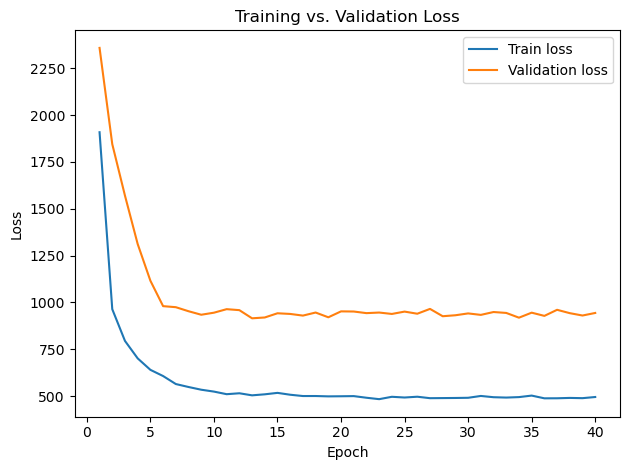

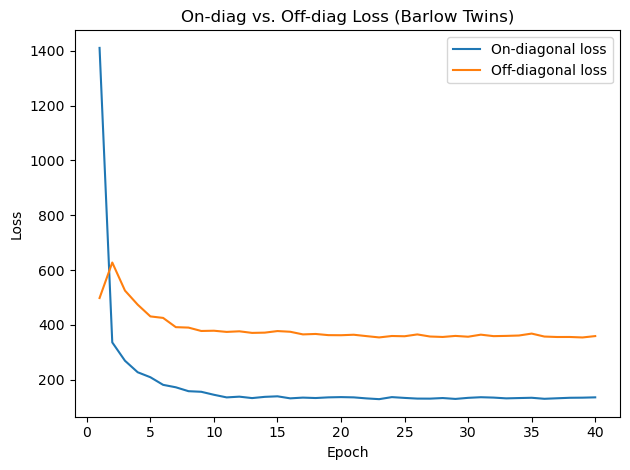

Figuras guardadas em:
 - /home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb/loss_train_vs_val.png
 - /home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb/loss_train_vs_val.pdf
 - /home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb/loss_on_vs_off_diag.png
 - /home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb/loss_on_vs_off_diag.pdf


In [47]:
# === PLOTAR HISTÓRICO DO BARLOW TWINS ===
# Ajusta este caminho para a tua pasta do run:
RUN_DIR = "/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Tb"

import json, pickle, os
from pathlib import Path
import matplotlib.pyplot as plt

run = Path(RUN_DIR)
hist_path = run / "history.json"

def load_history_any(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"history.json não encontrado em: {path}")
    # tenta JSON texto
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception:
        # tenta pickle binário
        with open(path, "rb") as f:
            data = pickle.load(f)
    # normaliza para dict de listas
    if isinstance(data, list):
        keys = sorted({k for d in data for k in d.keys()})
        out = {k: [] for k in keys}
        for d in data:
            for k in keys:
                out[k].append(d.get(k, None))
        return out
    return data

hist = load_history_any(hist_path)

# helpers
def get_series(key):
    v = hist.get(key, None)
    return v if isinstance(v, list) and len(v) > 0 else None

train_loss = get_series("train_loss") or get_series("loss")
val_loss   = get_series("validation_loss") or get_series("val_loss")
on_diag    = get_series("on_diag_loss")
off_diag   = get_series("off_diag_loss")

epochs = range(1, (len(train_loss) if train_loss else len(val_loss) or len(on_diag) or len(off_diag)) + 1)

# === (1) Training vs Validation Loss ===
if train_loss or val_loss:
    plt.figure()
    if train_loss: plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:   plt.plot(epochs, val_loss,   label="Validation loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs. Validation Loss")
    plt.legend(); plt.tight_layout()
    plt.savefig(run / "loss_train_vs_val.png", dpi=200)
    plt.savefig(run / "loss_train_vs_val.pdf")
    plt.show()

# === (2) On-diag vs Off-diag Loss ===
if on_diag or off_diag:
    plt.figure()
    if on_diag:  plt.plot(epochs, on_diag,  label="On-diagonal loss")
    if off_diag: plt.plot(epochs, off_diag, label="Off-diagonal loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("On-diag vs. Off-diag Loss (Barlow Twins)")
    plt.legend(); plt.tight_layout()
    plt.savefig(run / "loss_on_vs_off_diag.png", dpi=200)
    plt.savefig(run / "loss_on_vs_off_diag.pdf")
    plt.show()

print("Figuras guardadas em:")
for fn in ["loss_train_vs_val.png","loss_train_vs_val.pdf",
           "loss_on_vs_off_diag.png","loss_on_vs_off_diag.pdf"]:
    p = run / fn
    if p.exists(): print(" -", p)


# BCM

In [1]:
import pickle, types
import torch

pkl_path = "/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI_normal/model/Papyrus_TB/5.pkl"
obj = torch.load(pkl_path, map_location="cpu")
print(type(obj))

if isinstance(obj, dict):
    print("DICT KEYS:", list(obj.keys())[:30])


<class 'collections.OrderedDict'>
DICT KEYS: ['smiles_embedding.weight', 'protein_embedding.weight', 'smiles_cnn.layers.0.0.weight', 'smiles_cnn.layers.0.0.bias', 'smiles_cnn.layers.0.1.weight', 'smiles_cnn.layers.0.1.bias', 'smiles_cnn.layers.0.1.running_mean', 'smiles_cnn.layers.0.1.running_var', 'smiles_cnn.layers.0.1.num_batches_tracked', 'smiles_cnn.layers.1.0.weight', 'smiles_cnn.layers.1.0.bias', 'smiles_cnn.layers.1.1.weight', 'smiles_cnn.layers.1.1.bias', 'smiles_cnn.layers.1.1.running_mean', 'smiles_cnn.layers.1.1.running_var', 'smiles_cnn.layers.1.1.num_batches_tracked', 'smiles_cnn.layers.2.0.weight', 'smiles_cnn.layers.2.0.bias', 'smiles_cnn.layers.2.1.weight', 'smiles_cnn.layers.2.1.bias', 'smiles_cnn.layers.2.1.running_mean', 'smiles_cnn.layers.2.1.running_var', 'smiles_cnn.layers.2.1.num_batches_tracked', 'smiles_cnn.changeLayer.weight', 'smiles_cnn.changeLayer.bias', 'protein_cnn.layers.0.0.weight', 'protein_cnn.layers.0.0.bias', 'protein_cnn.layers.0.1.weight', 'prote

/tmp/ipykernel_595631/1551552896.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pkl_path, map_location="cpu")


In [4]:
import pandas as pd
df_L = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv")

In [5]:
df_L

,smiles,sequence,label,split
0,O=c1nc(N2CCN(C(=S)Nc3ccccc3)CC2)sc2ccc(Cl)cc12,MAAQKKKAQDEYGAASITILEGLEAVRKRPGMYIGSTGERGLHHLI...,0,train
1,CC(=O)c1c(-c2ccc(O)cn2)oc2ccc(O)c(CN3CCC4(COC4...,MADVAESQENAPAERAELTVPEMRQWLRNWVGKAVGKAPDSIDESV...,0,train
2,O=C(O)CN1Cc2cccc(NC(=O)OCC3c4ccccc4-c4ccccc43)...,MPPTVIAEPVASGAHASYSGGPGETDYHALNAMLNLYDADGKIQFD...,1,train
3,Fc1ccc(SSCCNC(=O)C(Cc2cccc(Br)c2)N=O)cc1,MSELRLMAVHAHPDDESSKGAATLARYADEGHRVLVVTLTGGERGE...,0,train
4,Cc1ccc(C(=O)CN2C(=O)C3(OCCO3)c3ccccc32)cc1,MTVTLCSPTEDDWPGMFLLAAASFTDFIGPESATAWRTLVPTDGAV...,0,train
...,...,...,...,...
8488,CN(C)CCCNC(=O)c1ccc2c(c1)N(Cc1ccc(Cl)cc1)C(=O)...,MQSWYCPPVPVLPGRGPQLRLYDSADRQVRPVAPGSKATMYVCGIT...,0,test
8489,CCCCCCC1=Cc2c\c(=C3\NN=C(O3)c3ccccc3OC)c(=O)oc...,MKARELDVPGAWEITPTIHVDSRGLFFEWLTDHGFRAFAGHSLDVR...,1,test
8490,CCN1CC[C@@H]2OC[C@H](C(=O)NCc3cccs3)C[C@@H]2C1,MSTPTGSRRIFSGVQPTSDSLHLGNALGAVAQWVGLQDDHDAFFCV...,0,test
8491,COc1ccc(cc1)C(CCC(=O)NO)P(O)(O)=O,MTNSTDGRADGRLRVVVLGSTGSIGTQALQVIADNPDRFEVVGLAA...,0,test


## tSNE

Selecionados: 60000 | TB=8493, Papyrus=51507
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='random', metric='jaccard', n_jobs=8,
     negative_gradient_method='fft', perplexity=60, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 180 nearest neighbors using NN descent approximate search using jaccard distance...


/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/openTSNE/nearest_neighbors.py:436: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  warnings.warn(
/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


   --> Time elapsed: 106.23 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.17 seconds
===> Running optimization with exaggeration=12.00, lr=5000.00 for 250 iterations...
Iteration   50, KL divergence 6.6792, 50 iterations in 2.5746 sec
Iteration  100, KL divergence 6.6025, 50 iterations in 2.5776 sec
Iteration  150, KL divergence 6.6005, 50 iterations in 2.5772 sec
Iteration  200, KL divergence 6.6001, 50 iterations in 2.5877 sec
Iteration  250, KL divergence 6.6001, 50 iterations in 2.5880 sec
   --> Time elapsed: 12.91 seconds
===> Running optimization with exaggeration=1.00, lr=60000.00 for 500 iterations...
Iteration   50, KL divergence 3.5382, 50 iterations in 2.8452 sec
Iteration  100, KL divergence 3.2104, 50 iterations in 4.1988 sec
Iteration  150, KL divergence 3.0421, 50 iterations in 6.0600 sec
Iteration  200, KL divergence 2.9362, 50 iterations in 8.1472 sec
Iteration  250, KL divergence 2.8600, 50 iterations in 10.0660 sec
Iteration  300, KL divergence 

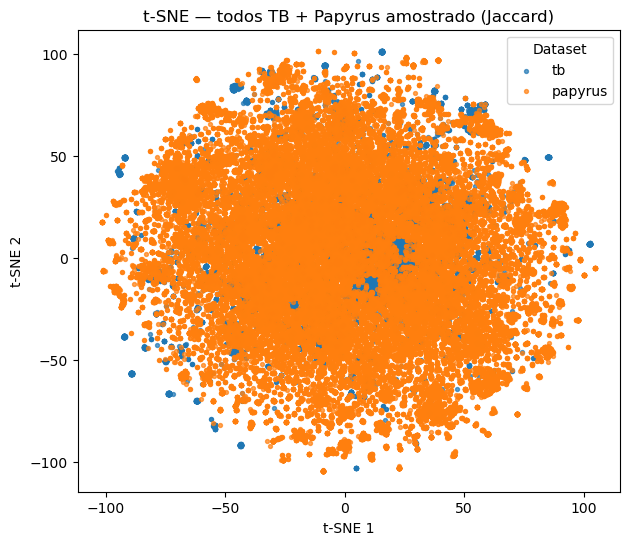

In [12]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from openTSNE import TSNE

# ============== CONFIG ==============
n_total = 60000       
nBits, radius = 1024, 2
perplexity = 60        # ajuste se mudar n_total
# ====================================

# 1) Ler datasets
df_pap = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_Barlow.csv"); df_pap["dataset"] = "Papyrus"
df_tb  = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv"); df_tb["dataset"]  = "tb"
df = pd.concat([df_pap, df_tb], ignore_index=True)

# 2) Separar TB e Papyrus
df_tb  = df[df["dataset"].str.lower() == "tb"].copy()
df_pap = df[df["dataset"].str.lower() == "papyrus"].copy()

# 3) Amostra: TODOS TB + Papyrus até n_total
n_tb = len(df_tb)
if n_tb >= n_total:
    df_sample = df_tb.sample(n_total, random_state=42).reset_index(drop=True)
else:
    n_pap_need = min(len(df_pap), n_total - n_tb)
    df_sample = pd.concat([df_tb, df_pap.sample(n_pap_need, random_state=42)], ignore_index=True)
df_sample = df_sample.sample(frac=1.0, random_state=42).reset_index(drop=True)

print(f"Selecionados: {len(df_sample)} | TB={sum(df_sample['dataset'].str.lower()=='tb')}, "
      f"Papyrus={sum(df_sample['dataset'].str.lower()=='papyrus')}")

# 4) Fingerprints (ECFP4) -> matriz esparsa
mols = [Chem.MolFromSmiles(s) for s in df_sample["smiles"]]
valid_idx = [i for i, m in enumerate(mols) if m is not None]
df_sample = df_sample.iloc[valid_idx].reset_index(drop=True)
mols = [mols[i] for i in valid_idx]

rows, cols, data = [], [], []
for i, m in enumerate(mols):
    onbits = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits).GetOnBits()
    rows.extend([i]*len(onbits))
    cols.extend(onbits)
    data.extend([1]*len(onbits))
X = csr_matrix((data, (rows, cols)), shape=(len(mols), nBits))

# (IMPORTANTE) Usar booleano para Jaccard e evitar conversões internas
X = X.astype(np.bool_)

# 5) t-SNE com openTSNE sem PCA: usar inicialização aleatória
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    metric="jaccard",            # Jaccard ≡ Tanimoto para bits
    initialization="random",     # evita PCA (que não aceita sparse)
    negative_gradient_method="fft",
    n_jobs=8,                    # ajuste conforme sua máquina
    random_state=42,
    verbose=True
)

emb = tsne.fit(X)   # <<< agora aceita CSR + init random

# 6) Plot
fig, ax = plt.subplots(figsize=(7,6))
labels = df_sample["dataset"].str.lower().values
for grp in ["tb", "papyrus"]:
    idx = labels == grp
    ax.scatter(emb[idx,0], emb[idx,1], s=8, alpha=0.7, label=grp)
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE — todos TB + Papyrus amostrado (Jaccard)")
ax.legend(title="Dataset")
plt.show()



/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(angular_rp_forest=True, metric='jaccard', n_jobs=1, random_state=42, verbose=True)
Thu Sep 18 08:00:36 2025 Construct fuzzy simplicial set
Thu Sep 18 08:00:37 2025 Finding Nearest Neighbors
Thu Sep 18 08:00:37 2025 Building RP forest with 41 trees
Thu Sep 18 08:15:41 2025 metric NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	Stopping threshold met -- exiting after 5 iterations
Thu Sep 18 08:18:41 2025 Finished Nearest Neighbor Search
Thu Sep 18 08:18:48 2025 Construct embedding


/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:51]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [01:43]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [02:35]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [03:27]

	completed  80  /  200 epochs


Epochs completed:  51%| █████      102/200 [04:18]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [05:07]

	completed  120  /  200 epochs


Epochs completed:  71%| ███████    142/200 [06:02]

	completed  140  /  200 epochs


Epochs completed:  81%| ████████   162/200 [06:52]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [07:41]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [08:31]


Thu Sep 18 09:28:21 2025 Finished embedding


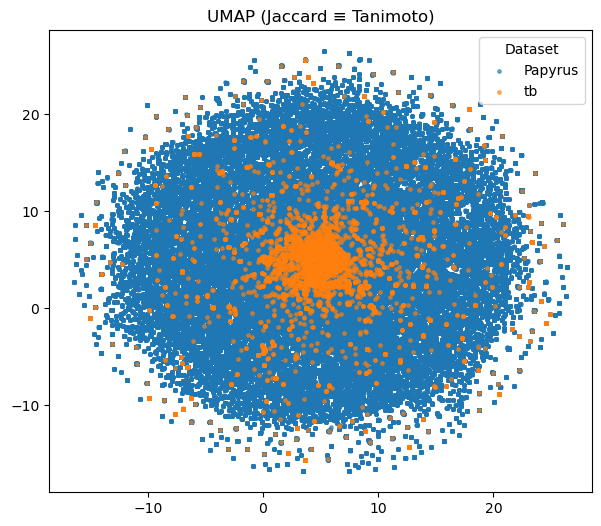

In [7]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from scipy.sparse import csr_matrix
import umap.umap_ as umap

# df: colunas ['smiles','dataset']
mols = [Chem.MolFromSmiles(s) for s in df['smiles']]
df = df[[m is not None for m in mols]].reset_index(drop=True)
mols = [m for m in mols if m is not None]

# fingerprints -> matriz esparsa binária (n_samples x nBits)
nBits = 2048; radius = 2
rows, cols, data = [], [], []
for i, m in enumerate(mols):
    on = list(AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits).GetOnBits())
    rows.extend([i]*len(on)); cols.extend(on); data.extend([1]*len(on))
X = csr_matrix((data, (rows, cols)), shape=(len(mols), nBits))

# UMAP com Jaccard (não cria matriz NxN)
um = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="jaccard",
    low_memory=True,      # reduz pico de RAM
    random_state=42,
    verbose=True
)
emb = um.fit_transform(X)

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,6))
for grp in df["dataset"].unique():
    idx = (df["dataset"] == grp).values
    ax.scatter(emb[idx,0], emb[idx,1], s=6, alpha=0.6, label=grp)
ax.legend(title="Dataset"); ax.set_title("UMAP (Jaccard ≡ Tanimoto)")
plt.show()
